## FFT Intuition & Python Implementations: 

The goal behind this notebook is not just for showing an algorithm implementation, but to go through the process of trying to implement an efficient algorithm to calculate the discrete fourier transfom, and see how a good algorithmic thinking process with a bit of analysis and observation would naturally lead to the fft algoritm.

Trying to understand this on my own while scworing the internet for clues and ideas has helped me alot and has definitley enhanced my algorithmic thinking, and I hope it does for you as well, lets dig in!

If you are unfamiliar yet with the Fourier Transform I highly recommend [this video by 3Blue1Brown](https://www.youtube.com/watch?v=spUNpyF58BY&list=PLKYWqKMe8hVIK-UgIO15KpMlcGz36aNN3&index=38&t=908s) 

**Discrete Fourier Transform (DFT):**
$$F_k = \sum_{n=0}^{N-1} g_n \cdot e^{-i~2\pi~k~n~/~N}~~~: k=[0, N-1] $$

This takes a discrete function $G[n]$ with size $N$, and produces a set of frequency magnitudes $F[k]$ for the frequencies that are available in the discrete function, these frequencies are described by ${\displaystyle \frac{k}{N}}$ where $k$ is an integer that belongs to the interval $[0, N-1]$

The approach one normally takes when implementing any algorithm would be to first make a naive brute force solution for the problem and see that everything works as expected, and then try to find some optimizations to improve the algorithm's efficiency.

A brute force algorithm for the DFT equation would have two nested for loobs, an outer loob going through values of $k$, and an inner loob for the values of $n$ while adding the calculated terms as we go. This yields an algorithm with $\mathcal{O}[N^2]$ complexity.
OK! lets do it and see its performance against the numpy implementation which uses a highly optimized version of the Fast Fourier Transform algorithm which has $\mathcal{O}[N\log N]$ complexity.

In [1]:
import cmath
import numpy as np

In [2]:
def naive_ft(g):
    sz = len(g)
    f = []
    for k in range(sz):
        f.append(0)
        for n in range(sz):
            f[k] += g[n] * cmath.exp(-2j * cmath.pi * k * n / sz)
    return f

In [3]:
x = np.random.random(2**10)
np.allclose(naive_ft(x), np.fft.fft(x))

True

In [4]:
%timeit naive_ft(x)
%timeit np.fft.fft(x)

2.82 s ± 32.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
32.6 µs ± 467 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Good! Our algorithm works, but $10^{5}$ times slower than the numpy implementation, That's Bad! But no worry we will certainly do better.

The first idea that comes to my mind when I see a sum of products $\sum_{n=0}^{N-1} a_n \cdot b_n$ is the Dot Product between vectors, which is computed very efficiently using numpy. Thus if we make a vector $A$ with all values of $a_n$ and a vector $B$ with all values of $b_n$, the sum of products for all $N$ becomes $A\cdot B$. But that gets rid of the inner for loob, how about the outer one that goes over the $k$ values? Well turns out we can get rid of it as well if we make the complex term of the DFT a matrix of size $[N*N]$ where rows represent different $k$ values and columns represent different $n$ values. 

OK! lets vectorize this operation and get rid of those for loobs.

In [5]:
def vectorized_naive_ft(g):
    sz = g.shape[0]  # The discrete function G[n], an (Nx1) vector
    k = np.arange(sz).reshape((sz, 1))  # vector containing values of k, with size (Nx1)
    n = k  # The n values are the same as k.
    power_mat = k.dot(n.T)  # an NxN matrix containing all the possible power of the complex term.
    e = np.exp(-2j * np.pi * power_mat / sz) # The complex term, an NxN Matrix
    return e.dot(g)

In [6]:
x = np.random.random(2**10)
np.allclose(vectorized_naive_ft(x), np.fft.fft(x))

True

In [7]:
%timeit vectorized_naive_ft(x)
%timeit np.fft.fft(x)

227 ms ± 3.18 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
31.7 µs ± 48.6 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


OK! That's much better we have become 10 times faster just by vectorizing our operations, but we are still far from the numpy implementation.

If we don't know any thing about fourier transform and are treating this as a normal equation without analyzing it, we would say that we have reached a dead end in terms of optimizations on the algorithm. Maybe we are doing unnecessary repeated calculations and we don't know about them, or maybe there are symmetries in the calculated terms we can make use of.Thus to optimize further we need to dive into the equation and get our brains dirty with theoritical information. 

There are two key ideas that we have to observe in the DFT equation which will greatly help us in optimizing our calculations even further.

### Key Idea 1: Range of possible frequencies depend on number of samples

The goal of Fourier Transform is to find the frequencies that our signal have and how  strong each frequency is. But what range of frequencies should we check? and at what resolution (i.e. step)? Fortunately this is easy to answer for discrete finite signals.

One just has to find three values, namely, the lowest frequency, the highest frequency, and the frequency step. Well in general, the frequency is (1/period), and in the discrete domain, the period is measured in number of samples. So, the maximum frequency should be (1/minimum_period), obviously the minimum period=1 (i.e. a period of only 1 sample), which means a pattern that repeats every sample (which is often called the DC component of the signal).

$$max~freq = 1$$

Similarly, we can say the minimum frequency is (1/maximum_period), obviously the maximum period is the total number of samples 'N' in the function.

$${min~freq= \frac{1}{N}}$$
                                                
Finally the frequency can be described by the period step, thus to cover all possible frequencies in this range, we use the minimum period step = 1 sample. The frequencies are described by this function:

$$f(k) = {\displaystyle \frac{k}{N}}$$, 

where k is an integer that belongs to the interval $[1, N]$.

The key idea to note here is that the range of possible frequencies is dependent on the number of samples, so if for examples the nunmber of samples were halved, the range of possible frequencies would also be halved.

You will notice that in the DFT equation we use the interval $[0, N-1]$ not $[1,N]$ for the values of $k$. Actually both those intervals and infinitly more intervals can be used because of the periodicity of the fourier transform (which is discussed in the second key idea below) where k=0 is same as k=N because the complex term would evaluate to $1$ in both.

This may seem irrelevant to optimizing the algorithm but it will actually help us arrive at the idea behind the Fast Fourier Transfrom algorithm.

### Key Idea 2: Symmetry and Peridoicity in the Discrete Fourier Transform

What's really interesting in the fourier transform equation is the complex term (which is what makes the difference in the DFT between different values of k): 

$$e^{-i~2\pi~k~n~/~N}$$ 

If you are a goemetry lover, thinking of complex numbers you think in 2-D, in other words you think of the complex plane, so it would definitely be interesting to visualize how this term behaves with different values of $n$ and $k$ in the complex plane.

In [8]:
import matplotlib.pyplot as plt

%matplotlib inline

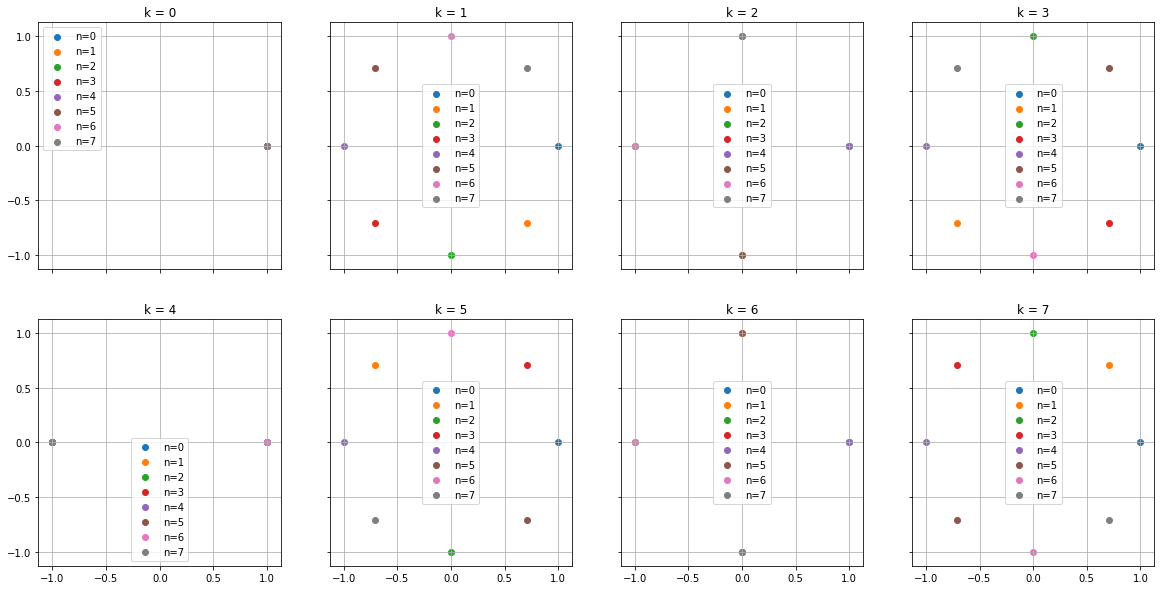

In [9]:
n_samples = 2**3
g = np.random.random(n_samples)
K = np.arange(n_samples).reshape(n_samples, 1)
N = K
c_term = np.exp(-2j * np.pi * K.dot(N.T) / n_samples)
f, ax = plt.subplots(2,n_samples//2,sharex='col',sharey='row', figsize=(20,10))
i = j = 0
for k in range(n_samples):
    if k < n_samples//2:
        j = k 
        i = 0
    else:
        j = k - n_samples//2
        i = 1
    for n in range(n_samples):
        x = np.real(c_term[k][n])
        y = np.imag(c_term[k][n])
        ax[i][j].scatter(x, y, label='n={}'.format(n))
    ax[i][j].grid()
    ax[i][j].legend()
    ax[i][j].set_title("k = {}".format(k))

Having a fast look, Tells us there's certainly some similarity between the values of $k$, but we need to point down what that similarity really is.

Looking at $k=0$ and $k=4$, I can't figure out how to relate them, but i can see that $k=0$ has only one value which is $1$, while $k=4$ has only two values either $1$ or $-1$.

I move on to $k=1$ and $k=5$ because they certainly look similar, well for $n=0, 2, 4, 6$ the complex term at $k=1$ equals that at $k=5$, while for $n=1, 3, 5, 7$ the complex term at $k=1$ equals negative that at $k=5$. This maybe true also for $k=3, 7$, $k=0, 4$ and $k=2, 6$ but i can't say for sure because the values of $n$ overlab each other.

OK! this seems interesting, we could say that for even values of $n$ the **complex term at $k =$ complex term at $\frac{N}{2} + k$**, while for odd values of $n$ the **complex term at $k =$ negative complex term at $\frac{N}{2} + k$**

But this isn't hard proof, this is just an observation, so to prove it we really have to go to algebra and see if we can obtain the same results.

**Discrete Fourier Transform (DFT) at $k=k$:**
$$F_k = \sum_{n=0}^{N-1} g_n \cdot e^{-i~2\pi~k~n~/~N}~~~: k=[0, N-1] $$

**Discrete Fourier Transform (DFT) at $k=\frac{N}{2}+k$:**
$$~~~~~~~~~~~~~~~F_{(\frac{N}{2}+k)} = \sum_{n=0}^{N-1} g_n \cdot e^{-i~2\pi~(\frac{N}{2}+k)~n~/~N}~~~: k=[0, \frac{N}{2}-1] $$
$$= \sum_{n=0}^{N-1} g_n \cdot e^{-i\pi~n}\cdot e^{-i~2\pi~k~n~/~N}$$

Hmm! We find that this term $e^{-i\pi~n}$ which is a function of $n$ only, is really what makes the difference between $F_k$ and $F_{(\frac{N}{2}+k)}$, but what does that evaluate to at different values of $n$ ?

If we know complex numbers, then we know eulers formula which states:
$$e^{i\theta} = \cos{\theta} + i\sin{\theta}$$

Then
$$e^{-i\pi~n} = \cos{(\pi~n)}-i\sin{(\pi~n)}$$

From trignometry we know that $\sin{(\pi~n)} = 0$ , for all positive integer values of $n$:
$$\sin{(0)} = 0$$
$$\sin{(\pi)} = 0$$
$$\sin{(2\pi)} = 0$$
$$\sin{(3\pi)} = 0$$
$$.$$
$$.$$
$$.$$
$$\sin{(\pi~n)} = 0$$

Similarly $\cos{(\pi~n)} = (-1)^{n}$ since it is $1$ for even values of $n$ and $-1$ for odd values of $n$ for all positive integer values of $n$:
$$\cos{(0)} = 1$$
$$\cos{(\pi)} = -1$$
$$\cos{(2\pi)} = 1$$
$$\cos{(3\pi)} = -1$$
$$.$$
$$.$$
$$.$$
$$\cos{(\pi~n)} = (-1)^{n}$$

Therfore the additional term that we found in $F_{(\frac{N}{2}+k)}$ reduces to:
$$e^{-i\pi~n} = (-1)^{n}$$

Finally:
$$F_{(\frac{N}{2}+k)} = \sum_{n=0}^{N-1} g_n \cdot (-1)^{n}\cdot e^{-i~2\pi~k~n~/~N}$$

so if $n$ is even (i.e. instead of $n$ we put $2n$ to give even values only):
$$F_{(\frac{N}{2}+k),~n=2n} = \sum_{n=0}^{\frac{N}{2}-1} g_{2n}\cdot e^{-i~2\pi~k~(2n)~/~N} = F_{k,~n=2n}$$

$$F_{(\frac{N}{2}+k),~n=2n} = F_{k,~n=2n}~~~: k=[0, \frac{N}{2}-1] $$

and if $n$ is odd (i.e. instead of $n$ we put $2n+1$ to give odd values only):
$$F_{(\frac{N}{2}+k),~n=2n+1} = -1 * \sum_{n=0}^{\frac{N}{2}-1} g_{2n+1}\cdot e^{-i~2\pi~k~(2n+1)~/~N} = -F_{k,~n=2n+1}$$

$$F_{(\frac{N}{2}+k),~n=2n+1} = -F_{k,~n=2n+1}~~~~: k=[0, \frac{N}{2}-1] $$

Aha!, we have found a great optimization that allows to compute only half the values of $k$ which are in the interval $[0, \frac{N}{2}-1]$ and then simply derive other half of the interval from what we have calculated in the first half, **But don't get confused we are still calculating $N$ number of frequencies, what we do is we compute the first half in a slow way and the second half of the interval in a faster way**.

It would be convenient to **split the big summation of $F_k$ into two smaller summations**, one for even values of $n$ that we call $F_{k,~2n}$, and one for odd values of $n$ that we call $F_{k,~2n+1}$, because we will use them in the calculation of the other half interval of $k$ ( i.e in the calculation of $F_{(\frac{N}{2}+k)}$ ).

The first N/2 number of frequencies [0, N/2] are calculated using this equation:

$$F_k = F_{k,~2n} + F_{k,~2n+1}$$

The second N/2 number of frequencies [N/2, N-1] are calculated using this equation:

$$F_{(\frac{N}{2}+k)} = F_{k,~2n} - F_{k,~2n+1}$$

$$F_{k,~2n} = \sum_{n=0}^{\frac{N}{2}-1} g_{2n}\cdot e^{-i~2\pi~k~(2n)~/~N}$$
$$F_{k,~2n+1} = \sum_{n=0}^{\frac{N}{2}-1} g_{2n+1}\cdot e^{-i~2\pi~k~(2n+1)~/~N}$$

Before we go any further lets test what we have reached so far and see that everything works.

In [10]:
def vectorized_not_so_naive_ft(g):
    sz = g.shape[0]  # The discrete function G[n], an (Nx1) vector
    
    if np.log2(sz) % 1 > 0:
        raise ValueError("must be a power of 2")
        
    g_even = g[::2] # even indices of G[n] (i.e. G[2n]) an (N/2 x 1) vector
    g_odd = g[1::2] # odd indices of G[n] (i.e. G[2n+1]) an (N/2 x 1) vector
    
    k = np.arange(sz//2).reshape((sz//2, 1))  # vector containing values of k[0,N/2 - 1], with size (N/2)x1
    
    n_even = np.arange(start=0,stop=sz,step=2).reshape((sz//2, 1)) # the even n values an (N/2 x 1) vector
    n_odd = np.arange(start=1,stop=sz,step=2).reshape((sz//2, 1)) # the odd n values an (N/2 x 1) vector
    
    power_mat_even = k.dot(n_even.T)# an N/2xN/2 matrix containing all the possible power of the even complex term.
    power_mat_odd = k.dot(n_odd.T) # same but for the odd
    
    e_even = np.exp(-2j * np.pi * power_mat_even / sz) # The complex term of the even part, an N/2xN/2 Matrix
    e_odd = np.exp(-2j * np.pi * power_mat_odd / sz)# The complex term of the odd part, an N/2xN/2 Matrix
    
    f_k_2n = e_even.dot(g_even) # F_k,2n
    f_k_2n_1 = e_odd.dot(g_odd) # F_k,2n+1
  
    f_k = np.hstack([f_k_2n + f_k_2n_1, # the first half of the interval of k [0, N/2 -1]
                     f_k_2n - f_k_2n_1])# the second half of the interval of k [N/2, N-1]
    return f_k

In [11]:
x = np.random.random(2**10)
np.allclose(vectorized_not_so_naive_ft(x), np.fft.fft(x))

True

In [12]:
%timeit vectorized_not_so_naive_ft(x)
%timeit vectorized_naive_ft(x)

135 ms ± 203 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
224 ms ± 1.89 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Well there's certainly improvement but not enough for all this work that we 've done, actually there's a little tweak remaining that will improve this by alot.

There's a constant part that doesn't depend on $n$ in the complex term of $F_{k,~2n+1}$, which comes from the $+1$ part of $2n+1$, lets take it out of the summation:
$$F_{k,~2n+1} = e^{-i~2\pi~k~/~N} \sum_{n=0}^{\frac{N}{2}-1} g_{2n+1}\cdot e^{-i~2\pi~k~(2n)~/~N}$$

lets call this term $c_k$ since it depends on $k$, and rename $F_{k,~2n}$ to $F_{k,~even}$ and $F_{k,~2n+1}$ to $c_k F_{k,~odd}$ because it's much easier to read:
$$F_{k,~2n+1} = c_k \sum_{n=0}^{\frac{N}{2}-1} g_{2n+1}\cdot e^{-i~2\pi~k~(2n)~/~N} = c_k F_{k,~odd}$$

$$F_{k,~2n} = \sum_{n=0}^{\frac{N}{2}-1} g_{2n}\cdot e^{-i~2\pi~k~(2n)~/~N} = F_{k,~even}$$

$$F_k = F_{k,~even} + c_k F_{k,~odd}$$

Now we see that the complex term is the same for $F_{k,~even}$ and $F_{k,~odd}$ now the only difference between them is that one takes the even half of the samples, and the other takes the odd half of samples (also the odd part gets multiplied by $c_k$ when calculating $F_k$ ).

Moreover each of $F_{k,~even}$ and $F_{k,~odd}$ are actually replicas of the original problem $F_k$ but with half the samples, This is more evident when we rewrite $F_{k,~even}$ and $F_{k,~odd}$ such that the $(\frac{2n}{N})$ part in the complex term becomes $(\frac{n}{N/2})$.

$$F_{k,~even} = \sum_{n=0}^{\frac{N}{2}-1} g_{2n}\cdot e^{-i~2\pi~k~n~/~(N/2)}$$

$$F_{k,~odd} = \sum_{n=0}^{\frac{N}{2}-1} g_{2n+1}\cdot e^{-i~2\pi~k~n~/~(N/2)}$$

But is it really half the size? I mean yes we compute half the samples for each but we still compute $N$ number of frequencies? no, actually if you remember **key idea 1** that we discussed, we said that the number of possible different frequencies are equal to the number of samples in the signal, and for the even/odd parts we they have half the number of samples so we only need to compute half the number of frequencies for each of them **(Therefore same problem but half it's size)**.

If you have taken any algorithms course or have experience with them in anyway, what I have just said should instantly click in your mind that this is the same as any divide and conquer problem, you start with a big problem, then you split it into to smaller problems of the same type and you keep going until tou can't split any more, the only difference is that we split it into even and odd parts instead of splitting an array from the middle.

What we have done so far was only split the problem once into an even and odd part to make use of the symmetry we have found and only calculate half the values of $k$ while other half we easily get from the calculated even and odd parts.

So what we should do now is split $F_{k,~even}$ and $F_{k,~odd}$ into another even and odd parts for each one and, and keep doing that until there's only one sample left in each of the last even and odd parts. Finally we compine each even and odd pairs from the bottom (1 sample) to the top (N samples) while making use of the symmetry at each level.

**A simple explanantion for how this should be much faster is this:**

$~~~~~~$If we have a signal with 8 samples (thus having 8 frequencies), what we have previously done is compute the first 4 frequencies slowly and then compute the remaining 4 from the first 4.

$~~~~~~$Now what we are trying to do is compute the 1st frequency slowly, then compute the 2nd frequency from the 1st, and then compute the 3rd & 4th from the 1st & 2nd, finally compute the remaining 4 from the first 4. So the difference here is that we have used the symmetry to it's fullest potential and instead of computing the first 4 samples slowly we have calculated only the 1st sample slowly and the rest came from each other thus calculated much faster.

Divide & Conquer goes hand in hand with Recursion, so this can be implemented using recursion, fortunately we have already found the recursion equation:

$$F_k = F_{k,~even} + c_k F_{k,~odd}$$

what's left now is to implement it:

In [13]:
def recursive_fft(g):
    sz = g.shape[0]
    if sz == 1:
        # end of recursion condition (i.e. we can't split anymore, size of dft = 1 sample),
        # and there's only one frequency, which is at k = 0, thus the complex term = 1.
        return g[0]
        
    # Calculate the first half part of the dft using recursion (i.e. the interval [0, sz // 2) ).
    f_even = recursive_fft(g[::2])  # the 2n (i.e. even) samples of g.
    f_odd = recursive_fft(g[1::2])  # the 2n+1 (i.e. odd) samples of g.
    
    k = np.arange(sz // 2)
    ck = np.exp(-2j * np.pi * k / sz)
    # Make use of the symmetry to calculate the other half part of the dft (i.e. the interval [sz // 2 , sz) ).
    return np.hstack([f_even + ck * f_odd,
                     f_even - ck * f_odd])
def fft(g):
    if np.log2(g.shape[0]) % 1 > 0:
        raise ValueError("must be a power of 2")
    return recursive_fft(g)

In [14]:
x = np.random.random(2**10)
np.allclose(fft(x), np.fft.fft(x))

True

In [15]:
%timeit fft(x)
%timeit np.fft.fft(x)

15.9 ms ± 25.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
34.3 µs ± 50.2 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


There's a ${10}$ fold improvement from before, but we are still $10^{3}$ times slower than numpy, and this is mainly because of vectorization, we can vectorize this solution and that's it, but we have now an algorithm that is $\mathcal{O}[N\log{N}]$, because we have $\log{N}$ recursion levels (because we can split $\log{N}$ times) and we do $N$ work at each level.

To vectorize this recursive algorithm, it's useful to look at the recursion tree ![](img/fft_recursion_tree.png)

[Image Source](https://people.eecs.berkeley.edu/~demmel/cs170_spr07/LectureNotes/Lecture_FFT.pdf)

Our target is to vectorize each level such that all these level's calculations are done using one vector/matrix product while moving level by level from the bottom of the recursion tree and making use of the symetry at each level. 

The recurision tree obliges us to compute children before their parents, but nothing more, the order of of the children calculation doesn't matter, and this makes things much easier for us, to see why is this , look at the lowest level of the tree above, the order of the even indices in that level is this $0,2,1,3$, and the odd indices that are paired with these even indices are $4,6,5,7$, now as you can see it's hard to figure out how to get this order right ourselves, but fortunately we don't need to do that at all, we will compute them in the order we want to, as long as we move from bottom to top and we know which are the even parts and which are the odd parts that are paired to them.

So we could re-arrange the pairs such that the even indices are $0,1,2,3$ thus the odd indices that are paired with them are $4,5,6,7$ , now you see this is much easier, this is like pairing the first half of the input array with the second half, and this will continue being true as we go up, the first half will be the even pairs, and the second half will be the odd pairs.

And that's it! so lets code this and see the results. 

In [18]:
def vectorized_fft(g):
    sz = g.shape[0]
    f = np.copy(g).reshape((1, sz))

    # Ensure the the discrete function (g) size is a power of 2.
    if np.log2(sz) % 1 > 0:
        raise ValueError("must be a power of 2")

    # Now we just move level by level from bottom to top of the recursion tree.
    # Calculating all the level at once, instead of recursively moving through the level pairs/dfts.
    # while also making use of the symmetry of the dft as before.
    while f.shape[0] < sz:
        # size of the dft at this level (i.e. number of samples / frequencies) = 2 * size of previous level.
        n = 2 * f.shape[0]
        # Get all the even and the odd pairs of the recursion tree at this level.
        f_even = f[:, : f.shape[1] // 2] # first half is the even pairs
        f_odd = f[:, f.shape[1] // 2:] # second half is the odd pairs
        # calculate the complex term for the first half part of the dft (i.e. interval=[0, n // 2) ).
        c_k = np.exp(-2j * np.pi * np.arange(n // 2) / n).reshape(n // 2, 1)
        # And here we make use of the symmetry of the dft, and calculate 2nd half from 1st half even and odd terms.
        f = np.vstack([f_even + c_k * f_odd,
                       f_even - c_k * f_odd])
    return f.ravel()

In [19]:
x = np.random.random(2**10)
np.allclose(vectorized_fft(x), np.fft.fft(x))

True

In [20]:
%timeit vectorized_fft(x)
%timeit np.fft.fft(x)

454 µs ± 1.54 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
31.5 µs ± 129 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Great! We are about $10^{2}$ times faster than noraml recursive fft, and we are only about $10$ times slower than the numpy implementation, this is because numpy's implementation is done using highly efficient low level implementation, but overal it's similar to this algorithm, congratulations! you have just a very good level of understanding for fft, and dft, and I also hope this helped you enhance your algorithmic thinking process.

**Resourses & Refrences:**

[Recursive Tree Image Source](https://people.eecs.berkeley.edu/~demmel/cs170_spr07/LectureNotes/Lecture_FFT.pdf)

Another good resourse for understanding fft is [this](https://jakevdp.github.io/blog/2013/08/28/understanding-the-fft/) which has helped me implement some of the codes.